### **Instalacion librerias**

In [17]:
pip install pandasql backtesting yfinance ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### **Importacion librerias**

**Pandas:** Manejo de nuestros datos en DataFrames

**Numpy:**  Operaciones y funciones numericas a los DataFrames

**Seaborn:** Visualizaremos la mayoria de nuestros datos con esta libreria

**Matplotlib:** Visualiremos los graficos que no se puedan graficas con 'seaborn'

**pandasql:** Manejo de datos de los DataFrames con queries SQL para aumentar el nivel del codigo

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandasql import sqldf

### **Importacion Datos**

**Datos:** 📈
* **syp:** Datos del S&P500 por dia 

* **nasdaq:** Datos del NASDAQ 

* **bonos:** Datos de los bonos del tesoro de los estados unidos

> Fuentes: Yahoo Finance

---

**Datos extras:** 📊
* **dist:** Datos de las empresas que conforman el S&P500 (1)
* **per:** Datos sobre el PE-ratio del S&P500 (2)
* **bube:** Datos sobre los bulls and bears markets del S&P500 (3)
* **sypm:** Datos del S&P500 por mes


> Fuentes: (1)Yahoo Finance, (2)MacroTrends, (3)SPglobal


In [19]:
syp = pd.read_csv("csv/S&P500.csv") #S&P500
nasdaq = pd.read_csv("csv/NASDAQ.csv") #NASDAQ
bonos = pd.read_csv("csv/US10Y.csv") #Bonos del tesoro EEUU
dist = pd.read_csv("csv/empresas_sp500.csv") #Empresas del S&P500
per = pd.read_csv("csv/sp500pe-ratio.csv") #PE-ratio del S&P500
bube = pd.read_csv("bulls&bears.csv") #Bulls & Bears markets del S&P500


In [20]:
# Agrupa los Datos del S&P500 por mes
syp['Date'] = pd.to_datetime(syp['Date'])
sypm = syp.set_index("Date")
sypm = sypm[["Open", "High", "Low", "Close"]]
sypm = sypm.resample('M').agg({'Open': 'first',
                                 'High': 'max',
                                 'Low': 'min',
                                 'Close': 'last'})

### **Evolución del Precio**

**Explicación:**

En este grupo de celdas veremos como ha evolucionado el precio del indice desde 1990, para ello utilizaremos la libreria 'backtesting' 📊 que nos posibilita hacer un grafico de barras interactivo con ipython del instrumento a evaluar.

---

Para trabajar en cada analisis establecemos una 'vista' similar a lo que son las 'views' en sql, son listas temporales con los datos que queremos explorar y asi no acumular variables basura. 🗑

In [21]:
vista = sypm

In [22]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

from backtesting.test import SMA, GOOG


class Mostrar(Strategy):
    def init(self):
        close = self.data.Close

    def next(self):
      return 

bt = Backtest(vista, Mostrar, cash=10000, commission=.002, exclusive_orders=True)

output = bt.run()
bt.plot()

/usr/local/lib/python3.8/dist-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '
<ipython-input-22-aeb8f36bc85b>:17: UserWarning: Superimposed OHLC plot matches the original plot. Skipping.
  bt.plot()


Row(id='1097', ...)

**Analisis:**

* En el grafico interactivo podemos ver que el indice tiene una macro-tendencia siempre a la alza, sobretodo en los ultimos años que ha aumentado el ritmo de crecimiento, lo cual hace pensar a algunos inversores que no es un crecimiento órganico y se trata de una burbuja financiera.

* Como observamos no todo son subidas, en el grafico podemos notar 3 principales correciones que ha sufrido el mercado a la baja por sucesos historicos.

  *   **2001:** La denominada [Burbuja puntocom](https://es.m.wikipedia.org/wiki/Burbuja_puntocom), sumado a los [Atentados del 11 de Septiembre de 2001](https://es.m.wikipedia.org/wiki/Atentados_del_11_de_septiembre_de_2001)
  *   **2008:** La [Gran Recesión](https://es.m.wikipedia.org/wiki/Gran_Recesi%C3%B3n)
  *   **2020:** La [Recesión por la pandemia COVID-19](https://es.m.wikipedia.org/wiki/Recesi%C3%B3n_por_la_pandemia_de_COVID-19)

  Curiosamente luego de cada una de estas caídas el rendimiento posterior del indice fue explosivo a la alza, normalmente registrando records en rendimiento.



### **Rendimiento**

**Explicación:**

Aqui evaluaremos el rendimiento anual que ha tenido el indice desde 1990 para ello acomodaremos nuestros datos con 'sqldf' y luego graficaremos con 'seaborn'.

---

Creamos una tabla agrupada por año para ver el rendimiento anual que ha tenido el indice y luego graficamos. ✅

In [23]:
vista = sqldf("SELECT strftime('%Y', Date) AS Anio, Close, ROUND((Close / LAG(Close) OVER (ORDER BY Date) -1), 2) AS Rendimiento FROM syp GROUP BY strftime('%Y', Date)")
vista['Rendimiento'] = vista['Rendimiento'].shift(-1)

In [24]:
vista.to_csv("csv/Rendimiento_anual.csv")

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


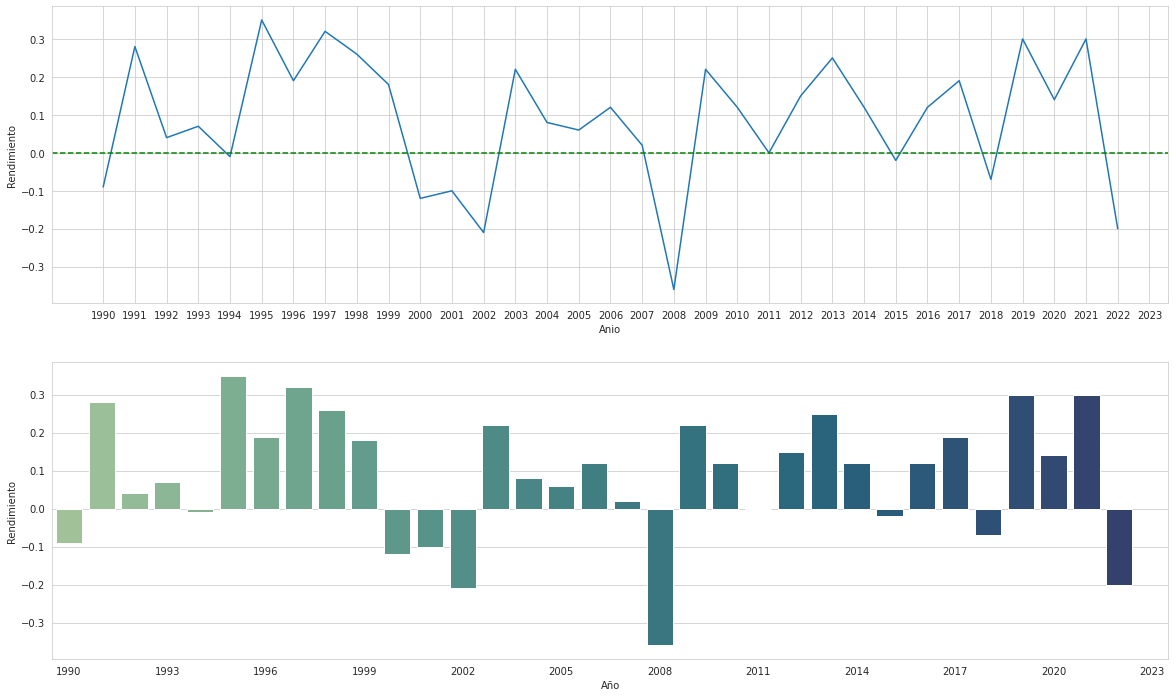

In [25]:
sns.set_style("whitegrid")


fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,12))
sns.lineplot(vista.Anio, vista.Rendimiento, palette="#118764", ax=axes[0])
axes[0].axhline(y=0, color='green', linestyle='--')

sns.barplot(vista.Anio, vista.Rendimiento, palette="crest", ax=axes[1])
plt.xlabel("Año")

plt.xticks(range(0, len(vista.Anio)+1, 3), vista.Anio[::3])
plt.show()

In [26]:
negativos = vista.loc[vista.Rendimiento < 0]
positivos = vista.loc[vista.Rendimiento > 0]

print(
  "Datos Rendimiento", "\n",
  f"Porcentaje años positivos: {round((len(positivos)/len(vista)*100),2)}%", "\n",
  f"Promedio rendimiento positivo: {positivos.Rendimiento.mean()}%", "\n",
  f"Promedio rendimiento negativo: {negativos.Rendimiento.mean()}%", "\n",
  f"Máximo positivo: {positivos.Rendimiento.max()}%", "\n",
  f"Minimo positivo: {positivos.Rendimiento.min()}%", "\n",
  f"Máximo positivo: {negativos.Rendimiento.max()}%", "\n",
  f"Minimo positivo: {negativos.Rendimiento.min()}%", "\n"
)


Datos Rendimiento 
 Porcentaje años positivos: 67.65% 
 Promedio rendimiento positivo: 0.1782608695652174% 
 Promedio rendimiento negativo: -0.1311111111111111% 
 Máximo positivo: 0.35% 
 Minimo positivo: 0.02% 
 Máximo positivo: -0.01% 
 Minimo positivo: -0.36% 



**Analisis:**

* Notamos que en la mayoría de años, el S&P500 tuvo rendimientos positivos en un 70% de los casos, además de tener un promedio de rendimiento 4 puntos mayor en los casos positivos.

* Las caídas no han logrado sobrepasar el -35% lo cual puede ayudarnos a establecer un margen de riesgo a la hora de invertir.

* Concluimos que para los datos, es mejor tener dinero en el S&P500 que tenerlo inmovil en efectivo.

#### Rendimiento por tendencias

**Explicación:**

El mercado puede tomar 2 valoraciones tendenciales "Alcista" 📈 los llamados **(Bulls markets 🐮)** o pueden ser "Bajista" 📈 también conocidos como **(Bears markets 🐻)**. En este analisis compararemos sus duraciones y rendimientos promedios para saber si es conveniente o no invertir en el S&P500 a largo plazo.

---

Dividimos nuestros datos 'bube' en _bulls markets_ y _bears markets_ y graficamos tanto su promedio de rendimiento como su promedio de duración en meses.

In [27]:
bulls = bube.loc[bube.grupo == "bulls"]
bears = bube.loc[bube.grupo == "bears"]

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'meses')

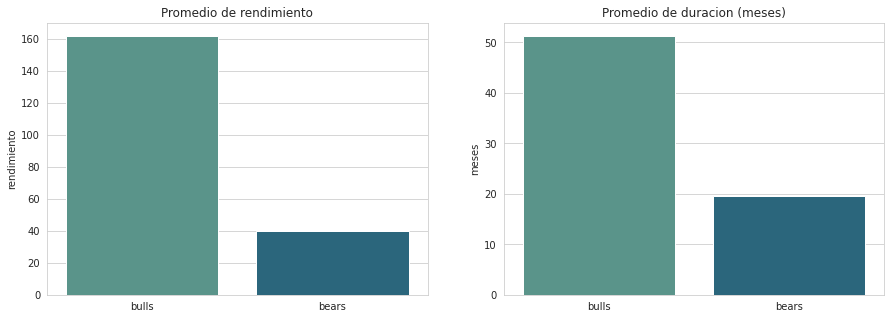

In [28]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
sns.barplot(["bulls", "bears"], [bulls.rendimiento.mean(), bears.rendimiento.mean()*-1], palette = "crest", ax = axes[0])
axes[0].set_title("Promedio de rendimiento")
axes[0].set_ylabel("rendimiento")


sns.barplot(["bulls", "bears"], [bulls.duration.mean(), bears.duration.mean()], palette = "crest", ax = axes[1])
axes[1].set_title("Promedio de duracion (meses)")
axes[1].set_ylabel("meses")

**Analisis:**

* En el **grafico (1)** podemos apreciar como el rendimiento en las temporadas alcistas es bastante superior al de las temporadas bajistas lo cual refuerza el analisis de rendimiento anterior.

* En el **grafico(2)** presenciamos que la duración de los bulls market es tambien bastante mayor a su comparado, esta larga duracion tambien guarda relación con los altos rendimientos. Mientras mas duradero sea el bull market, mayor el rendimiento.

> *Se refiere a un Bear Market a un periodo que empieza con un 20% de declive frente al mercado anterior.

### **Distribucion del S&P500**

**Explicación:**

Por acá veremos cuales son las 5 empresas más influyentes en el marketcap del S&P500 y la distribución de los sectores que lo componen.

---

Hacemos los ajustes al Dataframe para poder graficar y luego graficamos.

In [29]:
dist.columns = ['Symbol', 'Name', 'Sector', 'Price', 'Price/Earnings', 'Dividend Yield',
       'Earnings/Share', '52 Week Low', '52 Week High', 'Market Cap', 'EBITDA',
       'Price/Sales', 'Price/Book', 'SEC Filings', 'Peso']

,Symbol,Name,Peso
51,AAPL,Apple Inc.,3.255493
27,GOOGL,Alphabet Inc Class A,2.951124
28,GOOG,Alphabet Inc Class C,2.929856
311,MSFT,Microsoft Corp.,2.774796
30,AMZN,Amazon.com Inc,2.758287


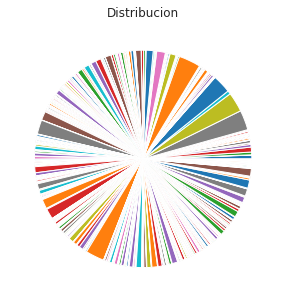

In [30]:
fig, ax = plt.subplots(figsize = (10,5))
plt.pie(dist.Peso)
ax.set_title("Distribucion")
dist[["Symbol", "Name", "Peso"]].nlargest(5, "Peso")

Buscamos el número de empresas que hay y su porcentaje en el total de empresas y su peso ponderado por marketcap 🏋💰

In [31]:
vista = dist.value_counts("Sector").reset_index()
peso_p = sqldf("SELECT Sector, ROUND(SUM(Peso), 2) AS Peso_marketcap FROM dist GROUP BY Sector ORDER BY Peso_marketcap desc")

vista.columns = ["Sector", "Cantidad"]
vista["Peso"] = vista.Cantidad.apply(lambda x: round(x/vista.Cantidad.sum() * 100, 2))
vista = vista.merge(peso_p)
vista.sort_values("Peso_marketcap", ascending = False)

,Sector,Cantidad,Peso,Peso_marketcap
1,Information Technology,70,13.86,27.05
2,Financials,68,13.47,13.84
4,Health Care,61,12.08,13.05
0,Consumer Discretionary,84,16.63,12.92
3,Industrials,67,13.27,9.70
5,Consumer Staples,34,6.73,8.39
7,Energy,32,6.34,5.46
9,Materials,25,4.95,2.78
6,Real Estate,33,6.53,2.51
8,Utilities,28,5.54,2.46


**Analisis:**

* Pudimos observar que las empresas con más capitalizacion en el S&P500 son empresas que van muy ligadas al sector tecnológico con una longevidad bastante corta en comparacion a otros valores del indice.

* En la siguiente tabla evidenciamos lo anterior, el sector 'Information Technology' representa mas de 27% de toda la capitalizacion, a pesar de que solo el 13.86% pertenece a este sector, teniendo más de 1/4 de toda la capitalizacion entre los 10 sectores del instrumento.

### **Estacionalidad**

**Explicación:**

En esta sección del analisis buscaremos encontrar relaciones entre los meses y el rendimiento del indice para saber en que meses es estadisticamente mas recomendable invertir. No consideré la relacion entre dias y rendimiento pues el ruido que puede haber es mucho mayor debido a hechos puntuales de ese momento. 📅

---

Acomodamos nuestros datos a solo los necesarios y generamos el rendimiento por mes para luego graficarlo. ✅

In [33]:
sypm = sypm.reset_index()
sypm.columns = ['Date', 'Open', 'High', 'Low', 'Close']

In [34]:
rendimiento_mensual = sqldf("SELECT strftime('%Y-%m', Date) AS Date, ROUND((Close / LAG(Close) OVER (ORDER BY Date) * 100 - 100), 2) AS Rendimiento FROM sypm")
rendimiento_mensual['Date'] = pd.to_datetime(rendimiento_mensual['Date'])
vista = sqldf("SELECT strftime('%m', Date) as mes, AVG(Rendimiento) AS Rendimiento FROM rendimiento_mensual GROUP BY strftime('%m',Date)")

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


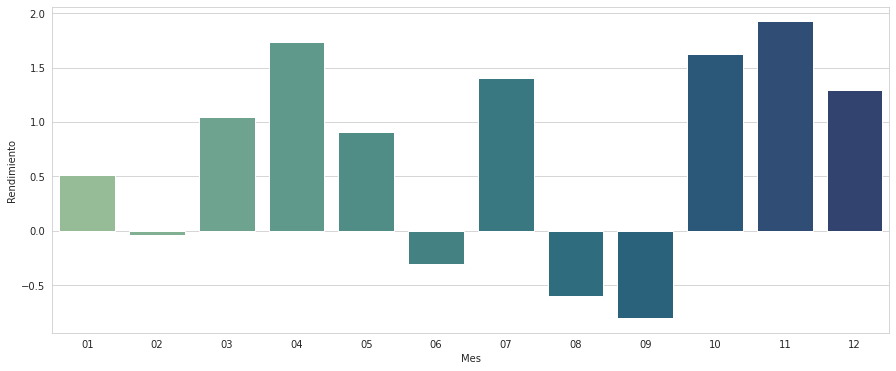

In [35]:
sns.set_style("whitegrid")


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,6))

sns.barplot(vista.mes, vista.Rendimiento, palette="crest")
plt.xlabel("Mes")
plt.show()

**Analisis:**
* En cuanto a la estacionalidad del indice, podemos ver queal igual que el rendimiento anual, la mayoría de casos es positivo.

* Notamos tambien que luego de una racha de rendimiento negativo, suele haber una correción fuerte con altos valores positivos

* Una estrategia lógica es invertir en el indice en Septiembre ya que suele ser el mes con promedios más bajos de rendimiento lo cual supone precios mas bajos del indice que favorecerían a los rendimientos altos de los proximos meses, buscaremos vender nuestras posiciones en el indice cuando antes de que se acerquen estos meses de rendimientos negativos. 

### **Relaciones con otros instrumentos**

**Explicación**

Por último, utilizaremos un recurso bastante frecuente en los analistas de mercados bursatiles que es la comparación con otros instrumentos financieros para la busqueda de patrones o correlaciones, cabe destacar que no se busca hacer una comparativa de precios si no de las formas que tienen las graficas. 📈 

---

Ajustamos nuestros datos pasando algunos a periodos mensuales para facilitar su comprension en los graficos. Luego procedemos a graficas en un subplot, multiples comparativas entre el 🟢 **S&P500** 🟢 y otros instrumentos o metricas. 📊

In [36]:
per.columns = ['Date', 'PEratio']

In [37]:
bono_mensual = sqldf("SELECT strftime('%Y-%m', Date) AS mes, Close FROM bonos GROUP BY strftime('%Y-%m', Date)")
per_mensual = sqldf("SELECT strftime('%Y-%m', Date) AS mes, AVG(PEratio) AS PEratio FROM per WHERE strftime('%Y', Date) >= '1990' GROUP BY strftime('%Y-%m', Date)")

Text(0.5, 1.0, 'S&P500 contra su PE-ratio')

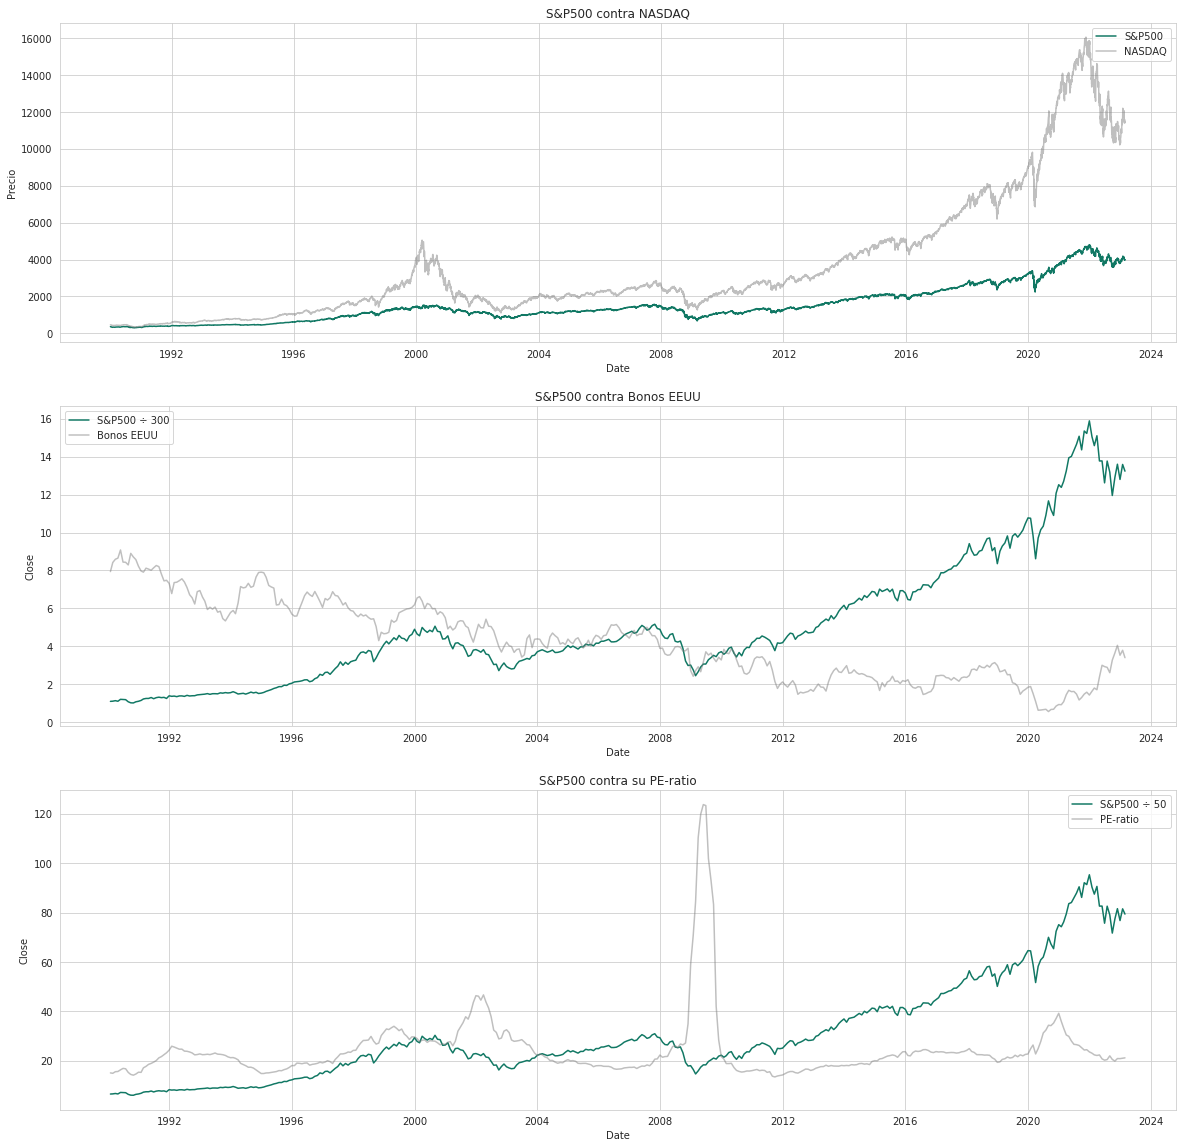

In [38]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20,20))

color = "#117864"

sns.lineplot(x = syp.Date, y = syp.Close, color = color, ax=axes[0], label = "S&P500")
sns.lineplot(x = syp.Date, y = nasdaq.Close, color = "gray", alpha = 0.5, ax=axes[0], label = "NASDAQ")
axes[0].set_title("S&P500 contra NASDAQ")
axes[0].set_ylabel("Precio")

sns.lineplot(x = sypm.Date, y = sypm.Close.apply(lambda x: x/300), color = color, ax=axes[1], label = "S&P500 ÷ 300")
sns.lineplot(x = sypm.Date, y = bono_mensual.Close, color = "gray", alpha = 0.5, ax=axes[1], label = "Bonos EEUU")
axes[1].set_title("S&P500 contra Bonos EEUU")

sns.lineplot(x = sypm.Date, y = sypm.Close.apply(lambda x: x/50), color = color, ax=axes[2], label = "S&P500 ÷ 50")
sns.lineplot(x = sypm.Date, y = per_mensual["PEratio"], color = "gray", alpha = 0.5, ax=axes[2], label = "PE-ratio")
axes[2].set_title("S&P500 contra su PE-ratio")



**Analisis:**

* En el **grafico (1)** podemos ver que el **NASDAQ** y el **S&P 500** tienen una forma casi identica excepto por algunas brechas de tiempo excepcionales, aunque si es destacable el hecho de que el **NASDAQ** a diferencia del **S&P500** tiene mucha mas volatilidad y rangos de precios mas amplios, en cambio el **S&P500** parece comportarse de forma más conservadora. Esto se puede deber a que la diversificacion del **NASDAQ** no es tan grande como su contraparte, y el hecho de que el **S&P500** a diferencia, si contiene empresas del **sector financiero**.

* En el **grafico (2)** notamos una **relación inversa** en gran parte del grafico entre los _'Bonos del tesoro'_ y el indice, esto se debe principalmente a que los bonos del gobierno son considerados un **'activo refugio'** entre los inversionistas, lo que significa que durante las caidas del **S&P500**, los inversionistas suelen invertir en bonos para  proteger su capital de las caidas, cuando el mercado se normaliza, venden sus bonos y compran de vuelta el indice.

* En el **grafico (3)** apreciamos una curiosa relación entre el PE-ratio* y el propio precio del indice, cuando el PE-ratio sube _(generalmente despues de una caída fuerte)_ el indice se vuelve bastante atractivo para los inversionistas, provocando una especie de 'empujón' a un bull market.




---

> *El ratio precio-beneficio, PER o PE-ratio es una razón geométrica que se usa en el análisis fundamental de las empresas, especialmente en aquellas que cotizan en bolsa. Su valor indica cuántas veces se está pagando el beneficio neto anual de una empresa determinada al comprar una acción de esta.